# Setup

In [1]:
# Set OpenAI key in the environment
from google.colab import userdata
import os

api_key = userdata.get('ai_agents_openai')
os.environ['OPENAI_API_KEY'] = api_key

serper_api_key = userdata.get('serper_api')

In [26]:
!pip install -q grandalf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.4 MB/s eta 0:00:00


In [2]:
!pip install -q langchain-community langchain-openai langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.2/148.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 10.8 MB/s eta 0:00:00


In [3]:
from openai import OpenAI

from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.graph import START, StateGraph, END

from IPython.display import Markdown, Image
from typing_extensions import TypedDict

import json
import ast

In [4]:
# create openAI client
client = OpenAI()

In [5]:
COMPANY = 'Beat81'
LOCATION = 'DE'
POSITION = 'Data Analytics Working Student'
BACKGROUND = [
    "Former Senior Manager in Revenue Management and Analytics at Zalando",
    "Did Pro Bono at the UN",
    "Currently Founder of Data Heroes and Bitte",
]
INTERVIEWER = "Matthias Glöel" # only works for high-profile people

In [67]:
# Create a TypedDict Class to store information
class AgentState(TypedDict):
  # Initial Data
  company: str
  location: str # country, ISO Code
  position: str
  background: list
  interviewer: str

  # Generated Content
  company_data: str
  interviewer_data: str
  questions: str

  # App keys
  memory: list



# Researching the company

In [32]:
# Researching about the company with OpenAI web search
def research_company(state):
  # Inputs for web search
  state['company'] = COMPANY
  state['location'] = LOCATION

  print('---Researching Company---')
  # Call the responses API
  response = client.responses.create(
      model = "gpt-4.1",
      tools = [{"type": "web_search_preview",
              "user_location": {
                  "type": "approximate",
                  "country": state['location']
              }}],
      input = f"Research about {state['company']}"
  )

  # Store the outcome
  state['company_data'] = response.output_text

  # display(Markdown(state['company_data']))
  return state

In [8]:
# Test the function
example_data = research_company({'company': COMPANY})
example_data['company_data']

'BEAT81 ist ein Boutique-Fitnessanbieter, der sich auf hochintensives Intervalltraining (HIIT) spezialisiert hat. Das Unternehmen wurde 2018 von Tim Dettmann, einem ehemaligen Badmintonprofi, gegründet und hat seinen Hauptsitz in Berlin. ([tagesspiegel.de](https://www.tagesspiegel.de/berlin/berliner-wirtschaft/berliner-fitnessstudio-kette-beat81-kann-man-in-45-minuten-1000-kalorien-verbrennen-10975528.html?utm_source=openai))\n\n**Trainingskonzept:**\nDie 45-minütigen Workouts von BEAT81 kombinieren Kraft- und Ausdauerübungen und sind darauf ausgelegt, die Teilnehmer mindestens 15 Minuten lang über 81 % ihrer maximalen Herzfrequenz zu bringen. Dies soll den sogenannten Nachbrenneffekt (EPOC) auslösen, bei dem der Stoffwechsel angeregt wird und nach dem Training zusätzliche Kalorien verbrannt werden. ([de.beat81.com](https://de.beat81.com/?utm_source=openai))\n\n**Standorte:**\nBEAT81 betreibt derzeit 38 Studios in Deutschland, darunter in Städten wie Berlin, München, Köln, Düsseldorf u

# Research Interviewer

In [41]:
# Build the function to research about the interviewer
def research_interviewer(state):

  # Inputs for the web search
  state['company'] = COMPANY
  state['interviewer'] = INTERVIEWER
  state['location'] = LOCATION
  state['position'] = POSITION

  print('---Researching Interviewer---')
  # Call the responses API
  response = client.responses.create(
      model = "gpt-4.1",
      tools = [{"type": "web_search_preview",
              "user_location": {
                  "type": "approximate",
                  "country": state['location']
              },
                "search_context_size": "medium", # balanced scope
                }],
      input = f"Research about {state['interviewer']}, who works for {state['company']} located in {state['location']}"
  )

  # Update the AgentState
  state['interviewer_data'] = response.output_text

  # display(Markdown(state['interviewer_data']))
  return state



In [10]:
# Test the research interviewer function
example_data_interviewer = research_interviewer(example_data)
example_data_interviewer['interviewer_data']

'Matthias Gloël ist als Analytics Engineer bei BEAT81 tätig, einem Unternehmen mit Sitz in Berlin, Deutschland. ([career.beat81.com](https://career.beat81.com/departments/engineering?utm_source=openai)) BEAT81 wurde 2017 gegründet und bietet hochintensive Gruppenfitness-Workouts an, die durch Herzfrequenztechnologie optimiert werden, um maximale Ergebnisse in kürzester Zeit zu erzielen. ([startup-atlas.de](https://www.startup-atlas.de/company/beat81?utm_source=openai)) Das Unternehmen hat Standorte in mehreren deutschen Städten, darunter Berlin, München und Köln. ([de.beat81.com](https://de.beat81.com/?utm_source=openai)) '

# Generate Questions

In [49]:
def generate_questions(state):
  state['background'] = BACKGROUND
  # Define system message for AI that generates questions
  developer_message = f"""
  You are an AI that generates Interview questions to help prepare the user.
  Data:
  Company name: {state['company']}
  Interviewer: {state['interviewer']}
  User background: {state['background']}
  Job position: {state['position']}
  company_report from web search: {state['company_data']}
  Interviewer report from web search: {state['interviewer_data']}

  Output:
  1) 10 concise question in bullet form to mimic a job interview.
  2) Questions may touch upon the user's background, culture fit, job fit, or qualifications.
  """

  print('---Generating Questions---')
  response = client.responses.create(
      model = "gpt-4.1",
      input=[
          {"role": "developer", "content": developer_message}],)
  state['questions'] = response.output_text

  return state

In [18]:
# Test the generate questions function
example_data_questions = generate_questions({'interviewer_data': example_data_interviewer['interviewer_data'],
                                             'company': COMPANY,
                                             'background': BACKGROUND,
                                             'position': POSITION,
                                             'company_data': example_data['company_data'],
                                             'interviewer': INTERVIEWER})
display(Markdown(example_data_questions['questions']))

---Generating Question---


1. Can you walk me through a project at Zalando where you used analytics to drive a measurable business outcome?  
2. What motivated your shift from senior management roles to founding Data Heroes and Bitte?  
3. How has your experience working pro bono at the UN influenced your approach to data analytics or teamwork?  
4. At Beat81, much of our value comes from real-time data (e.g., heart rate sensors). What experience do you have working with real-time or streaming data?  
5. As a working student in data analytics, you may need to collaborate with both technical and non-technical teams. Can you give an example of translating complex analysis to stakeholders with varying data literacy?  
6. Beat81’s business model relies on innovative technology and rapid expansion. How would you prioritize analytics projects to support both user growth and operational excellence?  
7. What tools or programming languages are you most comfortable with for data analysis, and how have you applied them in past projects?  
8. How do you ensure data accuracy and reliability when working with datasets from multiple sources, such as membership platforms and fitness trackers?  
9. How do you stay up to date with the latest trends and technologies in data analytics, and what recent advancement excites you most?  
10. What draws you to Beat81’s mission and culture, and how do you see yourself contributing to our team?

In [74]:
# Build the function for the interviewer bot
def interview_bot(state):
  if not state.get('memory'):
    state['memory'] = []

  developer_message = f"""
  You are an AI that helps prepare the user for a job interview.
  Data:
  Company name: {state['company']}
  position: {state['position']}
  User background: {state['background']}

  You follow a pre-defined script.
  Ask the questions exactly as given, in order.
  After the answer of the user give actionable feedback tied to the role.

  questions:
  {state['questions']}

  Memory: {state['memory']}
  """

  print('---Interviewing---')
  response = client.responses.create(
      model = "gpt-4.1",
      input=[
          {"role": "developer", "content": developer_message}],)

  question = response.output_text
  display(Markdown(question))
  state['memory'].append(question)

  return state

In [75]:
# Build function to get an answer from the user
def get_answer(state):
  print('Please provide your answer')
  print('\n(Type "quit", "exit", "stop" or "end" to finish the practice)')
  user_input = input()
  state['memory'].append(f"User: {user_input}")
  state['terminate'] = user_input.lower().strip() in ['quit', 'exit', 'stop', 'end']

  return state

## Routers

In [76]:
# Function that decides to terminate the flow or not
def termination_router(state):
  return "End" if state.get('terminate') else "Continue"

# Build Workflow

In [77]:
# Initializint the StateGraph
workflow = StateGraph(AgentState)

# Set the entry point for the workflow
workflow.set_entry_point('Research Company')

# Define Nodes
workflow.add_node('Research Company', research_company)
workflow.add_node('Research Interviewer', research_interviewer)
workflow.add_node('Generate Questions', generate_questions)
workflow.add_node('Interview Bot', interview_bot)
workflow.add_node('Get Answer', get_answer)

# Define Edges
workflow.add_edge('Research Company', 'Research Interviewer')
workflow.add_edge('Research Interviewer', 'Generate Questions')
workflow.add_edge('Generate Questions', 'Interview Bot')
workflow.add_edge('Interview Bot', 'Get Answer')

# Add a contitional edge for get_answer to go back or end the flow
workflow.add_conditional_edges(
    "Get Answer",
    termination_router,
    {
        "Continue": "Interview Bot",
        "End": END
    }
)

# Compile the workflow
app = workflow.compile()

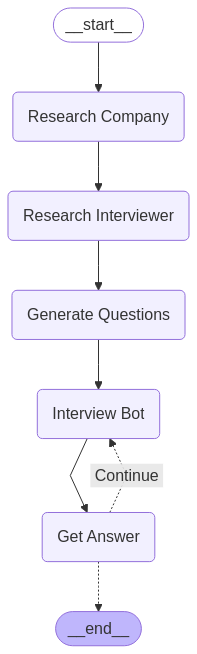

In [78]:
# Display the Graph
display(Image(app.get_graph().draw_mermaid_png()))

In [79]:
# # In case you have issues with the image
# app.get_graph().print_ascii()

In [80]:
# Test the app
result = app.invoke({'recursion_limit': 50})

---Researching Company---
---Researching Interviewer---
---Generating Questions---
---Interviewing---


Great, let’s get started!

1. Can you briefly walk us through your experience at Zalando, especially as it relates to data analytics and driving business decisions?

Please provide your answer

(Type "quit", "exit", "stop" or "end" to finish the practice)
At Zalando, I worked on large-scale analytics projects, focusing on customer behavior, A/B testing, and operational KPIs. I used tools like SQL, Python, and Tableau daily, and collaborated cross-functionally with product and marketing teams. This fast-paced, data-driven environment taught me how to extract insights quickly and communicate them clearly—skills that translate directly to a startup like Beat81, where agility and impact are key.
---Interviewing---


Thank you for sharing that! Your experience at Zalando with large-scale analytics, A/B testing, and cross-functional collaboration is highly relevant. For a working student role, especially at a fitness tech company like Beat81, it's great that you emphasized your use of SQL, Python, and Tableau, as well as your comfort with fast-paced environments.

Actionable feedback:
- For upcoming questions, consider highlighting specific examples with quantified outcomes (e.g., “improved KPI X by Y%”).
- Since Beat81 is smaller and more agile than Zalando, emphasize how you can break down complex analyses into bite-sized, actionable insights for teams with fewer resources or less analytics specialization.
- Directly mention how you can leverage your communication experience for cross-team initiatives, especially since student roles often interface with many parts of the company.

Let’s move to the next question:

2. What motivated your transition from managing analytics at a large company like Zalando to founding startups and now applying for a working student position at BEAT81?

Please provide your answer

(Type "quit", "exit", "stop" or "end" to finish the practice)
quit


* Export the reports (company and interviewer)
* Add your own questions
* Text to Speech and Speech to Text
* Case Studies to the interview